In [1]:
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from transformers import AutoModel

import numpy as np

import matplotlib.pyplot as plt

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = AutoModel.from_pretrained('prajjwal1/bert-tiny')
embeddings=model.embeddings.word_embeddings.weight
embeddings.shape

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([30522, 128])

In [3]:
C, H, W = 3, 4, 4
x = torch.arange(C*H*W).view(C, H, W)
print(x)
idx = torch.tensor([[0,1,2],])

print(x[list((torch.arange(x.size(0)), *idx.chunk(1)))])

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]],

        [[32, 33, 34, 35],
         [36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47]]])
tensor([[[ 0,  1,  2,  3],
         [20, 21, 22, 23],
         [40, 41, 42, 43]]])


In [4]:
torch.arange(8).repeat(6)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7])

In [5]:
torch.arange(48).reshape(8,6).T.reshape(-1)

tensor([ 0,  6, 12, 18, 24, 30, 36, 42,  1,  7, 13, 19, 25, 31, 37, 43,  2,  8,
        14, 20, 26, 32, 38, 44,  3,  9, 15, 21, 27, 33, 39, 45,  4, 10, 16, 22,
        28, 34, 40, 46,  5, 11, 17, 23, 29, 35, 41, 47])

In [6]:
class CodeBook(torch.nn.Module):

    def __init__(self, 
        levels, 
        feature_dim,
        num_words,
        feature_std         : float        = 1.0,
        feature_bias        : float        = 0.0,
        codebook_bitwidth=8):

        super().__init__()

        self.levels=levels
        self.feature_dim=feature_dim
        self.num_words=num_words
        self.feature_std=feature_std
        self.feature_bias=feature_bias
        self.bitwidth=codebook_bitwidth

        self.dictionary_size = 2 ** self.bitwidth
        self.dictionary = nn.ParameterList([])
        for i in range(levels):
            fts = torch.randn(self.dictionary_size, self.feature_dim) * self.feature_std + self.feature_bias
            self.dictionary.append(nn.Parameter(fts))

        self.feats=nn.Parameter(torch.randn(self.levels, self.num_words, self.dictionary_size))
    
    def forward(self, idx):
        output=[]
        for level in range(self.levels):
            logits = self.feats[level,idx.long()]
            #print(logits.shape)
            y_soft = torch.softmax(logits, dim=-1)
            #print(y_soft.shape)
            index = y_soft.max(-1, keepdim=True)[1]
            #print(index.shape)
            y_hard = torch.zeros_like(
                logits, memory_format=torch.legacy_contiguous_format
            ).scatter_(-1, index, 1.0)
            #print(y_hard.shape)
            keys = y_hard - y_soft.detach() + y_soft
            #print(keys.shape)
            out=(self.dictionary[level][None] * keys[..., None]).sum(-2)
            #print(out.shape)
            output.append(out)
        
        return torch.concat(output,-1)

class ApproxEmbed(torch.nn.Module):
    def __init__(self, 
        levels, 
        feature_dim,
        num_words,
        output_dims,
        feature_std         : float        = 1.0,
        feature_bias        : float        = 0.0,
        codebook_bitwidth=8,
        neurons=64,
        nn_levels=2):
        
        super().__init__()
   
        self.B=CodeBook(levels, 
                        feature_dim,
                        num_words,
                        feature_std= feature_std,
                        feature_bias= feature_bias,
                        codebook_bitwidth=8)
        
        self.N=torch.nn.Sequential()

        prec_dim = feature_dim*levels
        for i in range(nn_levels):
            self.N.append(torch.nn.Linear(prec_dim, neurons))
            self.N.append(torch.nn.LeakyReLU())
            prec_dim = neurons
        self.N.append(torch.nn.Linear(prec_dim, output_dims))

    def forward(self, idx):
        x = self.B(idx)
        x = self.N(x)
        return x


In [7]:
# embeds=torch.zeros((2,5,4))         # (L, W, C)
# embeds[1,0]=1
# embeds[0,2,1]=2

# idx=torch.randn((2,3,5))/10-1       # (L, B, W)
# idx[1,2,0]=10
# idx[0,0,2]=10
# idx[1,0,2]=10

# print(idx.shape, embeds.shape)
# apx.B.indexing_func(embeds,idx)

In [8]:
levels=8
channels=16
bits=8
device='cuda'
epochs=100
batch_size=2**13
neurons=64
nn_levels=2
n_embeddings=embeddings.shape[0]
embeddings_size=embeddings.shape[1]

In [9]:
torch.__version__

'2.0.0.dev20230123+cu117'

In [10]:
apx=ApproxEmbed(levels = levels, 
                feature_dim = channels,
                num_words = n_embeddings,
                output_dims = embeddings_size,
                feature_std = 0.1,
                feature_bias = 0.0,
                codebook_bitwidth=bits,
                neurons = neurons,
                nn_levels=nn_levels)
apx.to(device)
embeddings=embeddings.to(device)

optimizer=torch.optim.Adam(apx.parameters(),lr=0.01)
h=[]

In [11]:
import time

In [12]:
order=np.arange(embeddings.shape[0])
for epoch in range(epochs):

    t0=time.time()
    tot_loss=0
    np.random.shuffle(order)
    for batch in range(int(np.ceil(len(order)/batch_size))):
        
        positions = torch.tensor(order[batch*batch_size:(batch+1)*batch_size],dtype=int,device=device)
        embed_preds = apx(positions)
        
        embeds = embeddings[positions]
        loss=torch.mean(torch.square(embed_preds-embeds))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        tot_loss+=loss.detach().cpu()
        
    average_loss=tot_loss.numpy()/int(np.ceil(len(order)/batch_size))
    h.append(average_loss)
    print(epoch, f'{average_loss:.5g}'.ljust(80), time.time()-t0, end='\r')

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(len(h))+1,np.array(h))
plt.yscale('log')
plt.xscale('log')

Error in callback <function _draw_all_if_interactive at 0x000001B7DE80C820> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 640x480 with 1 Axes>

In [72]:
class Indexing(torch.autograd.Function):

    @staticmethod
    @torch.cuda.amp.custom_fwd(cast_inputs=torch.half)
    def forward(ctx, embeds, scores):
        ctx.save_for_backward(embeds, scores)
        # embeds.shape                                              # (L, W, C)
        s = scores.shape                                            # (L, B, W)
        idx = scores.max(-1)[1].T                                   # (B, L)
        idx = idx.reshape(-1)                                       # (B*L)
        out = embeds[list((torch.arange(s[0]).repeat(s[1]), idx))]  # (B*L, C)
        out = out.reshape(s[1],-1)                                  # (B, L*C)
        return out

    @staticmethod
    @torch.cuda.amp.custom_bwd
    def backward(ctx, grad_output):
        embeds, scores = ctx.saved_tensors
        grad_output=grad_output.view(-1, embeds.shape[0], embeds.shape[2])

        grad_embeds = grad_scores = None

        if ctx.needs_input_grad[0]:
            grad_embeds = torch.bmm(scores.permute(0,2,1), grad_output.permute(1,0,2))

        if ctx.needs_input_grad[1]:
            grad_scores = torch.bmm(grad_output.permute(1,0,2), embeds.permute(0,2,1))

        return grad_embeds, grad_scores


class CodeBook1(torch.nn.Module):

    def __init__(self, 
        levels, 
        feature_dim,
        num_words,
        feature_std         : float        = 1.0,
        feature_bias        : float        = 0.0,
        codebook_bitwidth=8):

        super().__init__()

        self.levels=levels
        self.feature_dim=feature_dim
        self.num_words=num_words
        self.feature_std=feature_std
        self.feature_bias=feature_bias
        self.bitwidth=codebook_bitwidth

        self.dictionary_size = 2 ** self.bitwidth
        self.dictionary = nn.Parameter(torch.randn(self.levels, self.dictionary_size, self.feature_dim) * self.feature_std + self.feature_bias)
        self.feats=nn.Parameter(torch.randn(self.levels, self.num_words, self.dictionary_size))
        self.indexing_func=Indexing.apply
    
    def forward(self, idx):
        logits=self.feats[:,idx.long()]
        return self.indexing_func(self.dictionary, logits)

class ApproxEmbed1(torch.nn.Module):
    def __init__(self, 
        levels, 
        feature_dim,
        num_words,
        output_dims,
        feature_std         : float        = 1.0,
        feature_bias        : float        = 0.0,
        codebook_bitwidth=8,
        neurons=64,
        nn_levels=2):
        
        super().__init__()
   
        self.B=CodeBook1(levels, 
                        feature_dim,
                        num_words,
                        feature_std= feature_std,
                        feature_bias= feature_bias,
                        codebook_bitwidth=8)

        # self.B=torch.compile(self.B,
        #             mode='max-autotune',
        #             fullgraph=True)
        
        self.N=torch.nn.Sequential()

        prec_dim = feature_dim*levels
        for i in range(nn_levels):
            self.N.append(torch.nn.Linear(prec_dim, neurons))
            self.N.append(torch.nn.LeakyReLU())
            prec_dim = neurons
        self.N.append(torch.nn.Linear(prec_dim, output_dims))

    def forward(self, idx):
        x = self.B(idx)
        x = self.N(x)
        return x

apx=ApproxEmbed(8,4,100,16)
idx=torch.tensor([3,69,3,6,1,2])
o=apx(idx)
loss=o.sum()
loss.backward()

In [73]:
apx=ApproxEmbed1(levels = levels, 
                feature_dim = channels,
                num_words = n_embeddings,
                output_dims = embeddings_size,
                feature_std = 0.1,
                feature_bias = 0.0,
                codebook_bitwidth=bits,
                neurons = neurons,
                nn_levels=nn_levels)
                
# apx=torch.compile(  apx,
#                     mode='max-autotune',
#                     fullgraph=True)
apx.to(device)
embeddings=embeddings.to(device)

optimizer=torch.optim.Adam(apx.parameters(),lr=0.02)
h1=[]
scaler=GradScaler()

In [74]:
T=[]

In [76]:
batch_size=2**14
order=np.arange(embeddings.shape[0])
H=[]
print(levels,channels)
for lr in [0.01]:
    apx=ApproxEmbed1(levels = levels, 
                feature_dim = channels,
                num_words = n_embeddings,
                output_dims = embeddings_size,
                feature_std = 0.1,
                feature_bias = 0.0,
                codebook_bitwidth=bits,
                neurons = neurons,
                nn_levels=nn_levels)
                
    # apx=torch.compile(  apx,
    #                     mode='max-autotune',
    #                     fullgraph=True)
    apx.to(device)
    embeddings=embeddings.to(device)

    optimizer=torch.optim.Adam(apx.parameters(),lr=lr)
    h1=[]
    scaler=GradScaler()
    for epoch in range(5000):

        t0=time.time()
        tot_loss=0
        np.random.shuffle(order)
        for batch in range(int(np.ceil(len(order)/batch_size))):
            t1=time.time()
            #with torch.autocast(device_type='cuda', dtype=torch.float16):
            t2=time.time()
            positions = torch.tensor(order[batch*batch_size:(batch+1)*batch_size],dtype=int,device=device)
            t3=time.time()
            embed_preds = apx(positions)
            t4=time.time()
            embeds = embeddings[positions]
            t5=time.time()
            loss=torch.mean(torch.square(embed_preds-embeds))
            t6=time.time()

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            t7=time.time()
            optimizer.step()
            optimizer.zero_grad()
            t8=time.time()

            tot_loss+=loss.detach().cpu()
            
        average_loss=tot_loss.numpy()/int(np.ceil(len(order)/batch_size))
        h1.append(average_loss)
        print(epoch, f'{average_loss:.5g}'.ljust(80), time.time()-t0, end='\r')
    H.append(h1)

8 16


KeyboardInterrupt: 

In [ ]:
T.append(H)

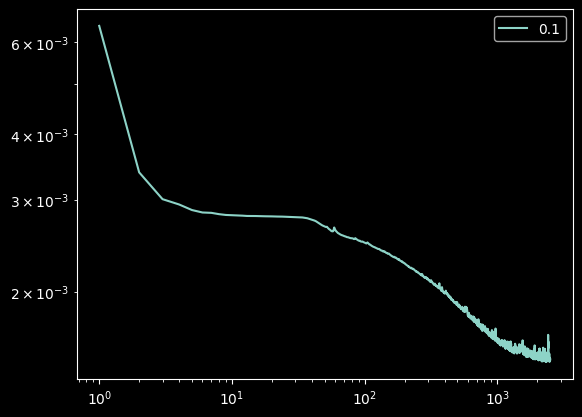

In [ ]:
for h1 in H:
    plt.plot(np.arange(len(h1))+1,np.array(h1))
    plt.yscale('log')
    plt.xscale('log')
plt.legend([0.1, 0.05, 0.02, 0.01])

In [ ]:
print(min(h1))
print(10*torch.log10(torch.max(embeddings)/min(h1)))

0.001467865309678018
tensor(26.0597, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
def calc_size(x):
   if isinstance(x,list) or isinstance(x,torch.nn.ParameterList):
      tot=np.sum([calc_size(elem) for elem in x])
   else:
      if isinstance(x,torch.Tensor):
         x=x.detach().cpu()
      x=np.array(x)
      tot=x.size * x.itemsize
   return tot

In [ ]:
int(calc_size([apx.B.dictionary, list(apx.N.parameters())])+ levels*n_embeddings*bits/8)

1190720

In [ ]:
S,V,D=np.linalg.svd(embeddings.detach().cpu(),full_matrices=False)

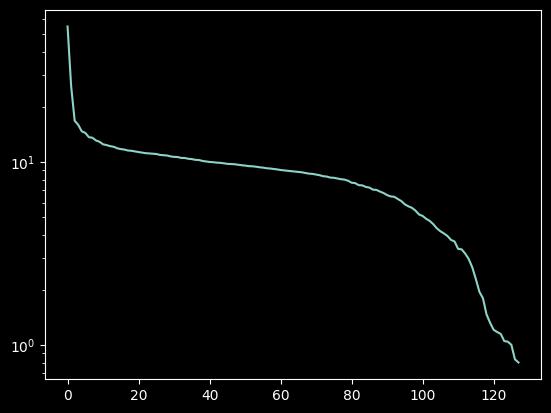

In [ ]:
plt.plot(V)
plt.yscale('log')

In [ ]:
n=4
print(torch.mean(torch.square(torch.tensor((S[:,:n]*V[:n])@D[:n],device=embeddings.device)-embeddings)).item())
print(10*torch.log10(torch.max(embeddings)/torch.mean(torch.square(torch.tensor((S[:,:n]*V[:n])@D[:n],device=embeddings.device)-embeddings))).item())

0.002376438118517399
23.96726131439209


In [ ]:
print('apx',int(calc_size([apx.B.dictionary, list(apx.N.parameters())])+ levels*n_embeddings*bits/8))
print('SVD',calc_size([S[:,:n],V[:n],D[:n]]))

apx 458192
SVD 490416


In [ ]:
calc_size([apx.B.dictionary, list(apx.N.parameters())])+ levels*n_embeddings*bits/8 

458192.0

In [ ]:
#APX=[]
APX.append(apx)

NameError: name 'APX' is not defined